In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
cd '/content/gdrive/My Drive/data'

/content/gdrive/My Drive/data


In [ ]:
#!pip install tldextract

In [6]:
import numpy as np
import pandas as pd
import re
import logging
import glob
import os
import torch
import tldextract
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns 
from urllib.parse import urlparse
from urllib.parse import unquote



In [7]:
path2=r"/content/gdrive/My Drive/tld"

In [8]:
path = r'/content/gdrive/My Drive/data'                     # use your path
all_files = glob.glob(os.path.join(path, "*.parquet"))
#logger = set_logger("./log/data.log")

**1**-  Data


In [9]:
logging.basicConfig(level=logging.WARNING)

def load_dataset(path):
  "Read all files in the dataset and convert them into a dataframe"
  all_files = glob.glob(os.path.join(path, "*.parquet"))
  if not all_files:
        raise ValueError('The folder is empty. Please enter another path')
  df_from_each_file = (pd.read_parquet(f, engine='pyarrow') for f in all_files)
  concatenated_df   = pd.concat(df_from_each_file, ignore_index=True)
  logging.info("Data loaded successfully")

  return concatenated_df

In [10]:
df=load_dataset(path)

2- Exploratory Data Analysis

In [11]:
def duplicated(df,mode):
  """Deal with duplicated rows"""
  #The dataset contains two types of duplications: 1/ the url and the target are duplicated  2/the url is duplicated with different targets
  #to take into account the recent day
  if mode=="last":
    df_no_dup=df.drop_duplicates(subset=["url"],keep="last", inplace=False)
  # to take into account take the intersection between the different targets of same url
  if mode=="intersection":
     df["target"]=df["target"].apply(set)
     df_no_dup=pd.DataFrame(df.groupby('url',as_index=True)["target"].agg(lambda x:set.intersection(*x)))
     df_no_dup.reset_index(level=0, inplace=True)
     df_no_dup["target"]=df_no_dup["target"].apply(list)
  return df_no_dup


In [13]:
logging.basicConfig(level=logging.WARNING)

def EDA(df,mode):
  " Function for Exploratory Data Analysis of Tags feature"
  """ 
    :param df: Dataframe
    :param mode: Method to remove the duplicate entries
    :return: Dataframe with no duplication
  """
  #remove missing data
  if df['target'].isnull().any():
    df=df.dropna(subset=['target'])

  labels=df["target"]
  #Number of unique labels
  count=len(set(labels.explode()))
  print(count)
  logging.info("Number of lables",count)
  logging.info("Number of rows in the dataset",len(df))

  #Checking for duplicate entries in the dataset
  boolean = df.duplicated(subset=['url']).any()

  if boolean:
    
    df_new= duplicated(df,mode="last")
    logging.info("Number of rows in the de-duplicated dataset",len(df_new))
    print("Total number of duplicate entries removed from the given dataset: ",len(df)-len(df_new))
  else:
    df_new=df

  #Checking for the distribution of number of tags per url
  df_new["tag_count"] = df_new["target"].apply(lambda tags: len(tags))
  plt.figure(figsize=(10,5))
  sns.countplot(df_new.tag_count, palette='gist_rainbow')
  plt.title("Distribution of the number of tags per url")
  plt.xlabel("Number of Tags")
  plt.ylabel("Number of url")
  plt.show()
  #Average of labels per url
  avg_tg=sum(df_new["tag_count"])*1/len(df_new["tag_count"])
  logging.info("Average  number  labels per url",avg_tg)
  logging.info("Max number of labels per url",max(df_new["tag_count"]))
  logging.info("Min number of labels per url",min(df_new["tag_count"]))

  #The number of times each tag appeared
  count=df_new["target"].explode().value_counts()
  plt.hist(count)
  plt.show()

  #drop column day and tag_count
  df_new=df_new.drop(["day",'tag_count'],axis=1)

  return df_new


1903
Total number of duplicate entries removed from the given dataset:  120


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


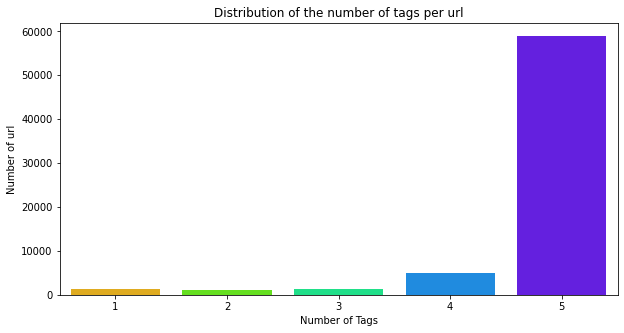

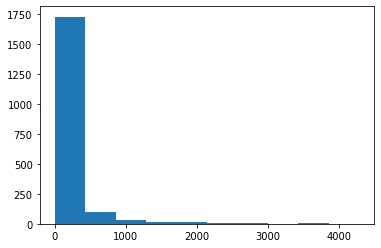

In [14]:
d=EDA(df,"last")